# Text Analytics Coursework -- Tasks 1.1 to 1.3

# Instructions:

This notebook is forms the first part of your coursework assignment for Text Analytics in Spring 2025. You will need to read the instructions below and complete numbered tasks indicated by "TASK n". To complete the tasks, you will write code or explanations between the comments "#WRITE YOUR ANSWER HERE" and "#END OF ANSWER". For example:

TASK 0: Complete the function below to output "hello world". 


In [13]:
def demo_fun():
    # WRITE YOUR ANSWER HERE
    print("hello world")
    # END OF ANSWER

### DO NOT MODIFY
demo_fun()
###

hello world


There is also some code in the cell that should not be modified. This code saves your results to file in the correct format, which is necessary for us to be able to mark your answers. Before you submit your notebook, please make sure this code has not been modified, then restart your kernel, clear all cell outputs, run all of your code once again, then save the notebook. 

Please note:
  * The notebook you upload must include all the saved cell output after running all cells.
  * The notebook code must be complete so that it reproduces all your output when we run it. 
  * For this coursework, we recommend that you use your virtual environment that you created for the labs. The packages you need are: numpy, scipy, nltk, pytorch, transformers and datasets (from HuggingFace), pandas, matplotlib and scikit-learn. 

## Marking guidelines:
1. This notebook is worth 32% of the marks for the Text Analytics assignment.
1. The number of marks for each task is shown alongside the task.
1. We will evaluate the output of your code after running it, and marks will be awarded based on how well the output matches the task's instructions. 
1. We will give partial marks for incomplete or partially correct answers. 
1. We do not give additional marks for code style or comments, but clear code will help us to understand what you have done so that we can award partial marks where necessary. 
1. Unless the task asks you to implement something from scratch, there is no penalty for using software libraries in your implementation.

## Support:

The main source of support will be during the lab sessions. The TAs and lecturers will help you with questions about the lectures, the code provided for you in this notebook, and general questions about the topics we cover. For the assessed tasks, they can only answer clarifying questions about what you have to do. Please email Edwin if you have any other queries edwin.simpson@bristol.ac.uk and/or post your query to the Teams channel for this unit.

## Deadline:

The notebook must be submitted along with the second notebook on Blackboard before **Monday 28th April at 13.00**. 

## Submission:

For this part of the assignment, please zip up the folder containing this file and the 'outputs' directory, containing the output from this notebook as .csv files. Please name your notebook file like this:
   * Name this notebook 'text_analytics_part1_\<student number\>.ipynb'. Replace '\<student number\>' with your student number, which consists only of digits beginning with '2'. 
   * We mark anonymously, so please don't include your name in the notebook.

You can submit the file on Blackboard to the submission point "Text Analytics Part 1 Notebook". Remember that the assignment also has parts 2 and 3, described in the PDF file on Blackboard.

# Setup: random seeds

Each student will work with slightly different data splits and model weights, which will be determined by setting your 'random seed'. 
We will check that your results come from using your random seed. Please set the seed in the cell below by changing the value of 'my_student_number' to your own student number (not your username, the number you can see on eVision that contains only digits). 

Using the correct seed ensures that your results are reproducible when we rerun your notebook.

In [14]:
import torch
import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

### SET YOUR SEED TO YOUR STUDENT NUMBER HERE
my_student_number = 2623567
set_seed(my_student_number)

# Setup: loading the data

Let's make a folder to save the output of your work:

In [16]:
import os
import pandas as pd

os.mkdir('./outputs')
# Output folder is created to save the results generated by the models

Now, let's load some more packages we will need later:

In [17]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



The dataset classifies paragraphs taken from corporate disclosures that discuss climate-related issues. It classifiers them into "risk" (0), "neutral" (1) or "opportunity" (2) representing the sentiment of the paragraph.

First we need to load the data. The data is already split into train, validation and test. The _validation_ set (also called 'development' set or 'devset') can be used to compute performance of your model when tuning hyperparameters, optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation is to not use a single fixed validation set, but instead use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [18]:
cache_dir = "./data_cache"

# load the original training set from HuggingFace
train_dataset = load_dataset(
    "climatebert/climate_sentiment",
    split="train",
    cache_dir=cache_dir,
)

# we're going to create a new validation set by splitting the data
dataset_splits = train_dataset.train_test_split(test_size=0.2)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]

train_texts = np.array(train_dataset["text"])
val_texts = np.array(val_dataset["text"])

train_labels = np.array(train_dataset["label"])
val_labels = np.array(val_dataset["label"])

print(f"Training dataset with {len(train_texts)} instances loaded")
print(f"Development/validation dataset with {len(val_texts)} instances loaded")

### DO NOT MODIFY
# save gold labels to file
pd.DataFrame(val_labels).to_csv('./outputs/val_labels.csv')

Training dataset with 800 instances loaded
Development/validation dataset with 200 instances loaded


In this notebook, you're going to build three different classifiers for this dataset, then compare how they work, and analyse the results. We are going to start by implementing a naïve Bayes classifier from scratch. 

We are going to begin by initialising some useful variables and doing some very simple pre-processing using CountVectorizer.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

num_classes = 3

def preprocess(train_texts):
    vectorizer = CountVectorizer(ngram_range=(2,2), tokenizer=word_tokenize)
    X = vectorizer.fit_transform(train_texts).toarray()
    num_features = X.shape[1]

    X_val = vectorizer.transform(val_texts).toarray()

    return X, X_val, vectorizer, num_features

X, X_val, vectorizer, num_features = preprocess(train_texts)

c:\Users\pc\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## TASK 1.1a

Complete the function below to compute the class priors, $p(y_n = c)$ for each class label $c$, where $y_n$ is the class label of document $n$. Do not use the Sklearn implementation to do this, but implement it yourself, e.g., using Numpy functions. The function must output the class priors as a list or Numpy array containing the probabilities. You do not need to apply any smoothing or regularisation.    (3 marks)

In [20]:
def compute_class_priors(texts, labels):
    priors = np.zeros(num_classes)

    ### WRITE YOUR ANSWER HERE
    total_docs = len(labels) # total number of documents
    for c in range(num_classes):
        priors[c] = np.sum(labels == c) / total_docs 
    # to compute the prior probability of each class risk, opportunity, and neutral
    # prior is necessary for the Naiive Bayes Calssifier
    ### END OF ANSWER
    return priors


class_priors = compute_class_priors(train_texts, train_labels)
print(class_priors)

### DO NOT MODIFY
pd.DataFrame(class_priors).to_csv('./outputs/11a_class_priors.csv')

[0.34375 0.4125  0.24375]


## TASK 1.1b

Complete the function below to extract n-gram features from the text, then compute the liklihood $p(x_{ni} = w | y_n = c)$ that the $i$ th n-gram in document $n$ is $w$, given that the class of $n$ is $c$. Again, do not use the Sklearn implementation to do this, but implement it yourself, e.g., using Numpy functions. The function must output the likelihoods as a 2D Numpy array containing probabilities. You should apply smoothing by adding counts of +1 to the counts of each feature.  (3 marks)

In [21]:
def compute_feature_likelihoods(X, labels):

    likelihoods = np.ones((num_features, num_classes))  # a 2D numpy array where you can store the likelihoods. Note that all values are initialised to one.

    ### WRITE YOUR ANSWER HERE
    for c in range(num_classes):
        X_c = X[labels == c]
        class_feature_counts = np.sum(X_c, axis=0) # frequency of the n-grams
        total_words_in_class = np.sum(class_feature_counts) # to get the total number of words in the each class

        likelihoods[:, c] = (class_feature_counts + 1) / (total_words_in_class + num_features)
        # here laplace smoothing is used by adding 1 to each feature count.
    ### END OF ANSWER
    return likelihoods

likelihoods = compute_feature_likelihoods(X, train_labels)

### DO NOT MODIFY
pd.DataFrame(likelihoods).to_csv('./outputs/11b_likelihoods.csv')

Now, we are going to use the code in the next cell to compute the log probabilities of each class for each text in the validation set. This code will use the previous functions you implemented, compute_class_priors and compute_feature_likelihoods. The log probabilities will be stored in the 'predictions' array.

In [22]:
from scipy.special import logsumexp


def NB_classify(class_priors, likelihoods, X_val):

    predictions = np.zeros((X_val.shape[0], num_classes))  # an empty numpy array to store the predictions in

    sum_of_log_likelihoods = X_val.dot(np.log(likelihoods))
    log_joint_prob = sum_of_log_likelihoods + np.log(class_priors)[None, :]
    for n, doc in enumerate(X_val):
        predictions[n, :] = log_joint_prob[n]
        predictions[n, :] -= logsumexp(predictions[n, :])
    return predictions

predictions = NB_classify(class_priors, likelihoods, X_val)
print(predictions)

[[-7.40870454e+00 -1.28701587e-03 -7.29307540e+00]
 [-5.68434189e-14 -3.04521899e+01 -3.62284680e+01]
 [-1.74295732e+01 -1.72042416e+01 -6.06936510e-08]
 [-3.42612126e+00 -9.80529928e-02 -2.79874650e+00]
 [-3.34870260e-03 -5.76152818e+00 -8.53331164e+00]
 [-2.85991127e+01 -3.19042966e-01 -1.29771339e+00]
 [-5.74959531e+01  0.00000000e+00 -4.92457374e+01]
 [-8.16658944e+01  0.00000000e+00 -6.64471621e+01]
 [-1.90482297e-10 -2.23815763e+01 -3.10746323e+01]
 [-2.38633491e+01 -5.54008352e-07 -1.44061646e+01]
 [-2.16284011e+01 -1.84132887e-09 -2.03608112e+01]
 [-1.43354365e+01 -6.49032459e-03 -5.04077805e+00]
 [-7.43855537e-08 -1.64201483e+01 -2.15093053e+01]
 [-1.66584186e-08 -1.79104599e+01 -2.70387361e+01]
 [-1.91257556e-01 -1.75139677e+00 -7.50783329e+00]
 [-1.89453949e+01 -5.91739990e-09 -2.95987332e+01]
 [-1.27250367e+01 -5.13622428e+00 -5.90019618e-03]
 [-1.69500941e+01 -5.61516312e-04 -7.48522800e+00]
 [-1.31367128e+00 -3.18801302e-01 -5.48495529e+00]
 [-1.24666411e+01 -1.74913472e-

Use the 'predictions' array above to compute and print the accuracy of the classifier on the validation set.   

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(val_labels, np.argmax(predictions, axis=1))

0.695

## TASK 1.1c

The simplicty of naïve Bayes means that we can quite easily interpret the model. In the code above, we used the functions you implemented, compute_feature_likelihoods and compute_class_priors, to train an NB classifier with our training set. Given this classifier, which are the five n-gram features that most strongly indicate that the document belongs to class 0? Store these features in the 'top_features' list below.    (4 marks)

In [24]:
top_features = []

### WRITE YOUR ANSWER HERE

# log likelihoods for each class 0,1,2
log_likelihoods = np.log(likelihoods)

#log-likelihood ratio between class 0 and max from the other classes
log_ratios = log_likelihoods[:, 0] - np.max(log_likelihoods[:, 1:], axis=1)

# top 5 strongest indicators for class 0
top_indices = np.argsort(log_ratios)[-5:][::-1]

# top features for class 0
top_features = [vectorizer.get_feature_names_out()[i] for i in top_indices]

### END OF ANSWER

### DO NOT MODIFY
print(top_features)
pd.DataFrame(top_features).to_csv('./outputs/11c_top_feats.csv')
###

['physical risks', 'of extreme', 'extreme weather', 'weather events', 'caused by']


Up to this point, the classifier used bigrams features extracted using CountVectorizer with the wordnet tokenizer. 

## TASK 1.1d

Your task is to improve the naïve Bayes classifier by changing the preprocessing or features only. It is up to you to decide how many changes are needed to improve the classifier -- a single change may be enough to achieve a good result (and maximum marks) and you should only include steps that help performance. Complete the 'preprocess_improved' function below, and run the cell to compute accuracy of the improved classifier on the validation set.     (3 marks)

In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocess_improved(train_texts):
     ### WRITE YOUR ANSWER HERE

    lemmatizer = WordNetLemmatizer()

    def lemmatize_tokens(text):
        return [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(text) if word.isalpha()]

    vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        tokenizer=lemmatize_tokens,
        stop_words='english',
        lowercase=False
    )

    X = vectorizer.fit_transform(train_texts).toarray()
    X_val = vectorizer.transform(val_texts).toarray()
    num_features = X.shape[1]

    ### END OF ANSWER

    return X, X_val, vectorizer, num_features


X, X_val, vectorizer, num_features = preprocess_improved(train_texts)
class_priors = compute_class_priors(train_texts, train_labels)
likelihoods = compute_feature_likelihoods(X, train_labels)
predictions = NB_classify(class_priors, likelihoods, X_val)
predictions_nb = np.argmax(predictions, axis=1)

### DO NOT MODIFY
pd.DataFrame(predictions_nb).to_csv('./outputs/11d_improved_preds.csv')
accuracy_improved = accuracy_score(val_labels, predictions_nb)
print(accuracy_improved)
###

c:\Users\pc\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\pc\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


0.755


## TASK 1.2

Below is an implementation of a neural network classifier that we can apply to the same dataset. However, there are some mistakes in the code and some poor choices in the choice of parameters and architecture. Your task is to fix the errors, make better parameter choices, and improve the model's performance. **Modify the code within the next cell** to improve the neural network classifier, then run it and compute its accuracy using the code in the cell after that.   (8 marks)

In [28]:
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE: MODIFY THE CODE WITHIN THIS CELL

from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from gensim.utils import tokenize
from gensim.corpora import Dictionary
import gensim.downloader
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# tokenising the text using Gensim
def tok_text(sample): 
    sample["tokens"] = list(tokenize(sample['text']))
    return sample

tok_train_dataset = train_dataset.map(tok_text)
tok_val_dataset = val_dataset.map(tok_text)

# creating the dictionary and then the vocabulary 
dictionary = Dictionary(tok_train_dataset["tokens"])
vocab_size = len(dictionary) + 1  # +1 for padding index - laplace smoothing

#converting the tokens to IDs
def encode_text(sample):
    input_ids = []
    for token in sample["tokens"]:
        if token in dictionary.token2id:
            token_id = dictionary.token2id[token] + 1
            if token_id < vocab_size:
                input_ids.append(token_id)
    sample["input_ids"] = input_ids
    return sample

pre_train_dataset = tok_train_dataset.map(encode_text)
pre_val_dataset = tok_val_dataset.map(encode_text)

# sequence length to pad
sequence_length = 80
def pad_text(sample):
    if len(sample['input_ids']) >= sequence_length:
        sample['input_ids'] = sample['input_ids'][:sequence_length]
    else:
        sample['input_ids'] = sample['input_ids'] + [0] * (sequence_length - len(sample['input_ids']))
    return sample

pad_train_dataset = pre_train_dataset.map(pad_text)
pad_val_dataset = pre_val_dataset.map(pad_text)

# coverting to the Dataloader
batch_size = 32
def convert_to_data_loader(dataset, shuffle=True):
    input_tensor = torch.tensor(dataset['input_ids'])
    label_tensor = torch.tensor(dataset['label']).long()
    return DataLoader(TensorDataset(input_tensor, label_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = convert_to_data_loader(pad_train_dataset)
val_loader = convert_to_data_loader(pad_val_dataset, shuffle=False)

num_classes = 3

# using the glove pre trained 100 D vector embeddings
glove_wv = gensim.downloader.load('glove-twitter-100')
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in glove_wv.index_to_key:
    if word in dictionary.token2id:
        idx = dictionary.token2id[word] + 1
        if idx < vocab_size:
            embedding_matrix[idx, :] = torch.tensor(glove_wv[word])

# LSTM-based classifier with pretrained embeddings and Dropout
class LSTMTextClassifierWithEmbeddings(nn.Module):
    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super().__init__()
        self.embedding_size = embedding_matrix.shape[1]
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.hidden_layer = nn.LSTM(self.embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Added dropout layer
        self.output_layer = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_words):
        embedded = self.embedding_layer(input_words)
        _, (hidden, _) = self.hidden_layer(embedded)
        hidden = hidden.permute(1, 0, 2).reshape(embedded.size(0), -1)
        h = self.activation(hidden)
        h = self.dropout(h)  # Apply dropout
        return self.output_layer(h)


#training the model with lr = 0.005 and adam optimizer and 15 epochs
def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.CrossEntropyLoss()
    all_dev_losses = []

    for e in range(num_epochs):
        model.train()
        train_losses, total_correct, total_trained = [], 0, 0

        for batch in train_dataloader:
            input_ids, labels = batch
            optimizer.zero_grad()
            output = model(input_ids)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            total_correct += (output.argmax(1) == labels).sum().item()
            total_trained += labels.size(0)

        model.eval()
        dev_losses, dev_correct, dev_total = [], 0, 0
        for batch in dev_dataloader:
            input_ids, labels = batch
            output = model(input_ids)
            dev_losses.append(loss_fn(output, labels).item())
            dev_correct += (output.argmax(1) == labels).sum().item()
            dev_total += labels.size(0)

        print(f"Epoch: {e+1}/{num_epochs}, "
              f"Train Loss: {np.mean(train_losses):.4f}, "
              f"Train Acc: {total_correct / total_trained * 100:.2f}%, "
              f"Val Loss: {np.mean(dev_losses):.4f}, "
              f"Val Acc: {dev_correct / dev_total * 100:.2f}%")

        all_dev_losses.append(np.mean(dev_losses))

    return model, all_dev_losses

#function that returns both true and predicted labels
def predict_nn(trained_model, data_loader):
    trained_model.eval()
    gold_labs = []
    pred_labs = []
    for batch in data_loader:
        input_ids, labels = batch
        with torch.no_grad():
            output = trained_model(input_ids)
        preds = output.argmax(dim=1)
        gold_labs.extend(labels.tolist())
        pred_labs.extend(preds.tolist())
    return gold_labs, pred_labs

embedding_size = 100
hidden_size = 128
lstm_model = LSTMTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
trained_model, _ = train_nn(15, lstm_model, train_loader, val_loader)

# predicting using the model 
gold_labs, predictions_nn = predict_nn(trained_model, val_loader)

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame(predictions_nn).to_csv("./outputs/12_nn_preds.csv")
accuracy_nn = accuracy_score(gold_labs, predictions_nn)
print(accuracy_nn)
###


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Epoch: 1/15, Train Loss: 1.0874, Train Acc: 39.12%, Val Loss: 1.0870, Val Acc: 40.50%
Epoch: 2/15, Train Loss: 1.0541, Train Acc: 45.50%, Val Loss: 1.0628, Val Acc: 49.00%
Epoch: 3/15, Train Loss: 0.9618, Train Acc: 55.00%, Val Loss: 0.9539, Val Acc: 53.50%
Epoch: 4/15, Train Loss: 0.9858, Train Acc: 51.25%, Val Loss: 1.1028, Val Acc: 43.00%
Epoch: 5/15, Train Loss: 0.9558, Train Acc: 54.25%, Val Loss: 0.9828, Val Acc: 50.50%
Epoch: 6/15, Train Loss: 0.9546, Train Acc: 57.38%, Val Loss: 0.9729, Val Acc: 50.50%
Epoch: 7/15, Train Loss: 0.9759, Train Acc: 54.62%, Val Loss: 1.0749, Val Acc: 46.00%
Epoch: 8/15, Train Loss: 0.9304, Train Acc: 58.88%, Val Loss: 0.9951, Val Acc: 48.50%
Epoch: 9/15, Train Loss: 0.8586, Train Acc: 60.62%, Val Loss: 0.9471, Val Acc: 52.00%
Epoch: 10/15, Train Loss: 0.9686, Train Acc: 52.62%, Val Loss: 1.2360, Val Acc: 33.50%
Epoch: 11/15, Train Loss: 1.0465, Train Acc: 46.50%, Val Loss: 1.0512, Val Acc: 42.00%
Epoch: 12/15, Train Loss: 0.9579, Train Acc: 54.00%,

We now explore the use of transformers for building a text classifier. First, let's look at how the process a document. We'll chose one at random from the training set:

In [29]:
### DO NOT MODIFY
chosen_document = train_texts[np.random.randint(len(train_texts))]

## TASK 1.3a

Use the HuggingFace transformers library to load the pretrained BERT model "prajjwal1/bert-tiny". Obtain a document embedding for the chosen document given above. Comment your code to explain how it obtains a representation of the document.    (3 marks)

In [31]:
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE

from transformers import AutoTokenizer, AutoModel
import torch

# using the tinyBERT pre trained model 
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

# tokenizing the documents 
inputs = tokenizer(chosen_document, return_tensors="pt", truncation=True, padding=True)

# model outputs
with torch.no_grad():
    outputs = model(**inputs)

# CLS token representation 
#as the document embedding
cls_embedding = outputs.last_hidden_state[:, 0, :] 

#covering to a list - doc_emb
doc_emb = cls_embedding.squeeze().tolist()

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame(doc_emb).to_csv('./outputs/13a_sen_emb.csv')
print(doc_emb)
###


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[-0.20534873008728027, 1.604604959487915, -4.565278053283691, -0.6396442651748657, -0.03463049978017807, 0.5766779780387878, -0.2684665024280548, 1.738054633140564, -0.4769549071788788, 0.880389392375946, 1.3154562711715698, 1.1971750259399414, -0.06102511286735535, 0.3221173584461212, 1.3446972370147705, -0.9198355078697205, -0.8521156907081604, -1.3179185390472412, -1.1516772508621216, 1.1152703762054443, -1.1078038215637207, 0.5770677328109741, 1.5537387132644653, 0.7789525389671326, 2.3459978103637695, -0.4306081533432007, -0.6871887445449829, -0.39781153202056885, -0.8344061374664307, 0.866350531578064, 0.4555981159210205, -2.0086631774902344, -0.5098251104354858, -0.9596834778785706, -0.06644666194915771, -1.627683401107788, -0.7683382630348206, 0.903235137462616, -0.8821029663085938, -0.3914729952812195, 0.6608697175979614, -0.15512506663799286, 0.3929893672466278, -2.5006582736968994, 0.13228638470172882, -2.1427958011627197, 0.2537946105003357, 0.4217519760131836, -0.812656760

## TASK 1.3b

Using the same document embeddings method as the previous task (1.3a), find the most similar document to the 'chosen_document' from within the validation set (from the 'val_texts' object). Use a standard similarity metric that considers the direction but not the magnitude of the embedding vectors.  (2 marks)

In [34]:
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# loading the model and tokenizer 
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")

# Again CLS tokens embedding 
def get_cls_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[0][0] 

# for a document
chosen_embedding = get_cls_embedding(chosen_document)

# Computing the cosine similarity between chosen doc and all the documents
#  in validation data
max_sim = -1
most_similar_doc = ""

for val_text in val_texts:
    val_embedding = get_cls_embedding(val_text)
    sim = F.cosine_similarity(chosen_embedding, val_embedding, dim=0).item()
    if sim > max_sim:
        max_sim = sim
        most_similar_doc = val_text

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame([chosen_document, most_similar_doc]).to_csv("./outputs/13b_most_similar.csv")
print(chosen_document)
print(most_similar_doc)
###


As a global company, we have a role and responsibility that extends even beyond the world of health. We are making progress to minimize our environmental impact and maintain resilient global operations by continuing to reduce greenhouse gas emissions —down 48% since 2008— and water consumption. We remain committed to reducing waste and increasing the use of renewable energy in alignment with our bold new sustainability goals for 2030.
Electricity Electricity is another significant source of carbon emissions. Since we began tracking our electricity use in 2014, our electricity consumption has decreased by 1% despite a 15% expansion in square footage and a 40% increase in headcount.49 Because of this growth, we were unable to achieve our initial 2020 goal of an 18% reduction. However, we continue to focus on reducing electricity through partnering with our landlords and leveraging energy efficiencies. Exhibit 10 provides additional data on our change in headcount versus electricity consu

## TASK 1.3c

Implement a classifier based on the same pretrained transformer model, "prajjwal1/bert-tiny". Evaluate your model's performance on the validation set. Use an 'auto class' from HuggingFace to build your classifier (see https://huggingface.co/docs/transformers/model_doc/auto).   (6 marks)

In [35]:
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# again loading the tinyBERT model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# tokenising
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

# tokenising the datasets 
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)


train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Accuracy metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# training the model
training_args = TrainingArguments(
    output_dir="./bert-tiny-results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="no",
    seed=my_student_number
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
)
trainer.train()

# predictions on the validation datset
predictions = trainer.predict(val_tokenized)
predictions_bert = np.argmax(predictions.predictions, axis=1).tolist()

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame(predictions_bert).to_csv('./outputs/13c_bert_preds.csv')
accuracy_tinybert = accuracy_score(val_dataset["label"], predictions_bert)
print(accuracy_tinybert)
###


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\pc\anaconda3\envs\text_analytics\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.012362,0.550000
2,No log,0.934255,0.570000
3,No log,0.843450,0.635000
4,No log,0.769831,0.720000
5,No log,0.712906,0.755000
6,No log,0.679034,0.760000
7,No log,0.651545,0.780000
8,No log,0.632862,0.775000
9,No log,0.627638,0.765000
10,0.678300,0.611236,0.765000


0.77


Comparison of model plottings

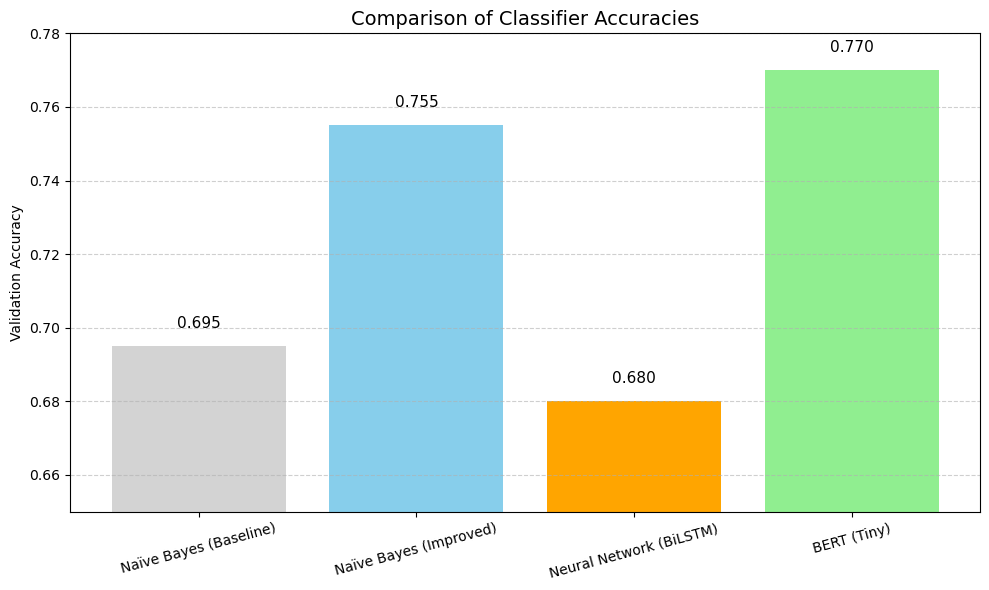

In [36]:
import matplotlib.pyplot as plt

# Accuracy values
methods = [
    "Naïve Bayes (Baseline)",
    "Naïve Bayes (Improved)",
    "Neural Network (BiLSTM)",
    "BERT (Tiny)"
]
accuracies = [0.695, 0.755, 0.680, 0.77]
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=["lightgrey", "skyblue", "orange", "lightgreen"])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, height + 0.005, f"{height:.3f}", fontsize=11)
plt.ylim(0.65, 0.78)
plt.ylabel("Validation Accuracy")
plt.title("Comparison of Classifier Accuracies", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [37]:
for i, (pred, true) in enumerate(zip(predictions_bert, val_labels)):
    if pred != true:
        print(f"Example {i}")
        print("Text:", val_texts[i])
        print("True Label:", true)
        print("Predicted:", pred)
        break

Example 6
Text: The British Columbia Carbon Tax Act sets a carbon price of $40 per tonne of CO2e on fuel combustion and is expected to increase by $5 per tonne of CO2e per year, reaching the federal target carbon price of $50 on April 1, 2021. The federal government has stated this program meets the requirements of the federal Greenhouse Gas Pollution Pricing Act. The CleanBC Program for Industry directs an amount equal to the incremental carbon tax paid by industry above $30/tonne into incentives to reduce emissions. The Government of British Columbia has also introduced measures to reduce upstream methane emissions by 45 percent and establish separate sector-level benchmarks to reduce carbon tax costs for industrial facilities.
True Label: 1
Predicted: 2


Confusion matrices 

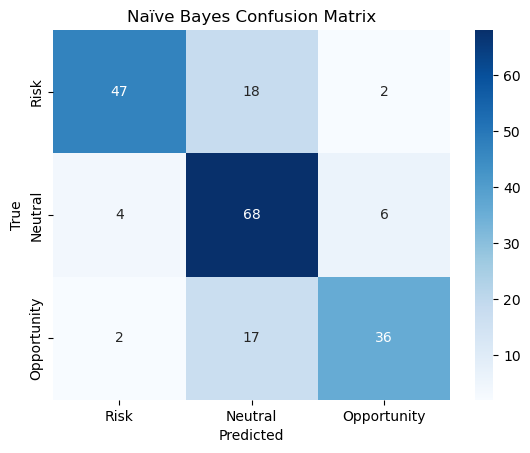

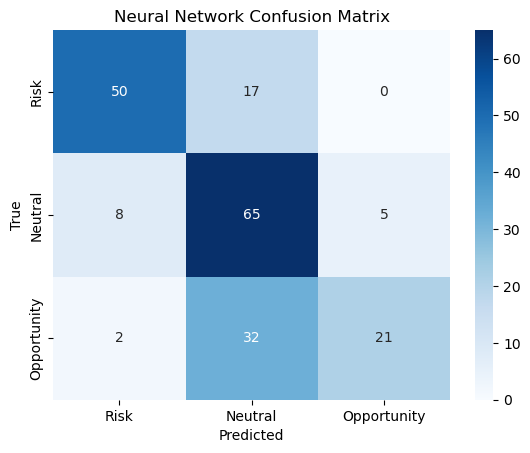

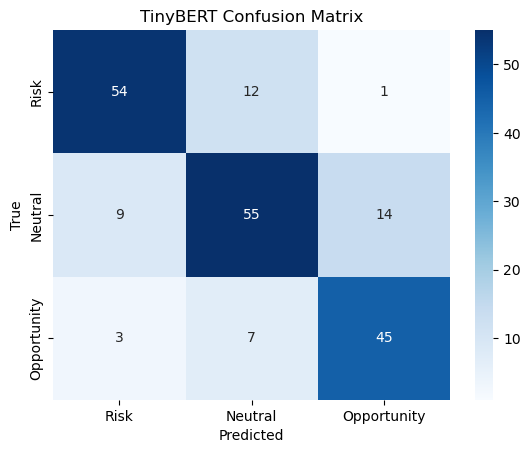

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Risk", "Neutral", "Opportunity"], yticklabels=["Risk", "Neutral", "Opportunity"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
plot_cm(val_labels, predictions_nb, "Naïve Bayes Confusion Matrix")
plot_cm(gold_labs, predictions_nn, "Neural Network Confusion Matrix")
plot_cm(val_dataset["label"], predictions_bert, "TinyBERT Confusion Matrix")
